In [1]:
from fastai import *
from fastai.vision import *

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [26]:
folder = 'panda'
file = 'urls_panda.txt'

In [60]:
folder = 'koala'
file = 'urls_koala.txt'

In [22]:
folder = 'kangaroo'
file = 'urls_kangaroo.txt'

In [61]:
#execute once per category
path = Path('data/animals')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [62]:
folder, file, path, dest

('koala',
 'urls_koala.txt',
 PosixPath('data/animals'),
 PosixPath('data/animals/koala'))

In [63]:
#execute once per category
download_images(path/folder/file, dest, max_pics=300)

In [31]:
classes = ['kangaroo','panda','koala']


In [32]:
for c in classes:
  print(c)
  verify_images(path/c, delete=True, max_workers=8)

kangaroo


panda


koala


In [33]:
doc(verify_images)


In [66]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [64]:
data.classes

['kangaroo', 'koala', 'panda']

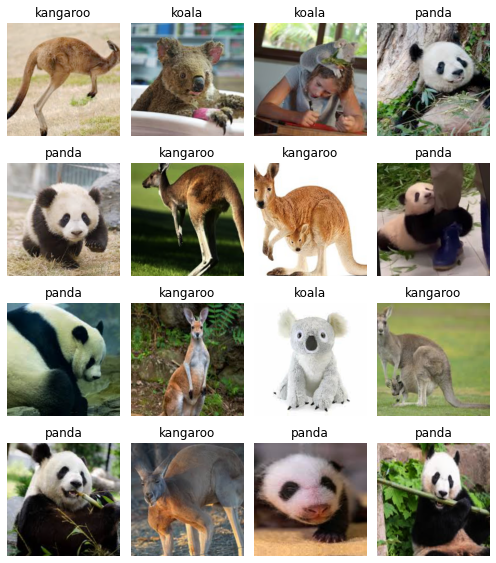

In [67]:
data.show_batch(rows=4, figsize=(7,8))

In [37]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['kangaroo', 'koala', 'panda'], 3, 69, 17)

In [ ]:
!pip install pytorch-lightning

# Pytorch Data Preprocessing

In [69]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import torch.nn.functional as F
import pytorch_lightning as pl
import helper
torch.cuda.is_available()

False

In [70]:
transforms = transforms.Compose([transforms.Resize(180),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data = datasets.ImageFolder('data/animals',transform=transforms)
# DataLoader takes a dataset and returns batches of images and coresponding labels

In [71]:
total = len(data)  # total number of examples
n_valid = int(0.2 * n)  # take ~20% for validation
val = torch.utils.data.Subset(data, range(n_test)) 
train = torch.utils.data.Subset(data, range(n_test, n)) 
# DataLoader takes a dataset and returns batches of images and coresponding labels
train_set = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
val_set = torch.utils.data.DataLoader(val, batch_size=16, shuffle=False)

Number of images in training set: 69
Number of images in test set: 17
Number of batches in the train loader: 5
Number of batches in the test loader: 2


In [72]:
def img_display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  npimg = np.transpose(npimg, (1, 2, 0))
  return npimg

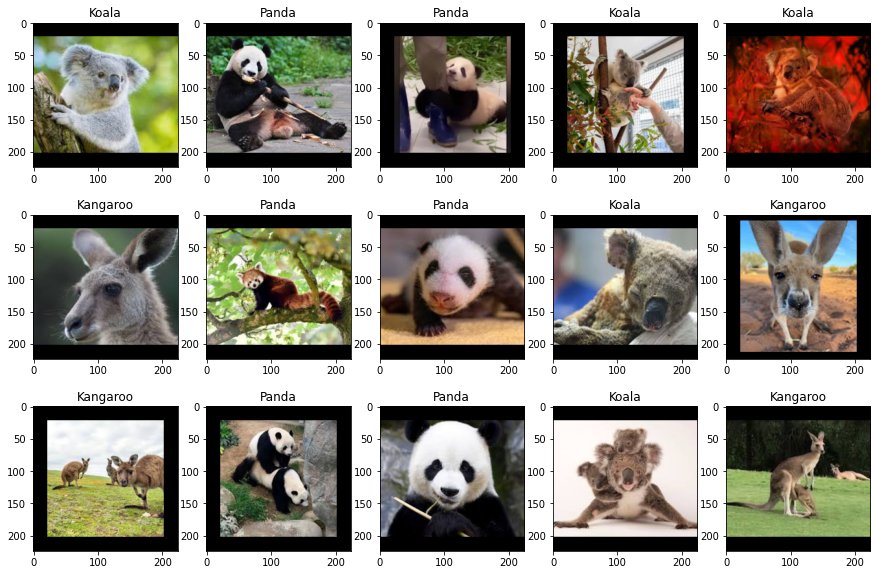

In [73]:
# get some random training images
dataiter = iter(train_set)
images, labels = dataiter.next()
animal_types = {0: 'Kangaroo', 1: 'Koala', 2: 'Panda'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
  with torch.no_grad():
      image, label = images[i], labels[i]
      ax.imshow(img_display(image)) # add image
      ax.set(title = f"{animal_types[label.item()]}") # add label

In [74]:
images.shape

torch.Size([16, 3, 224, 224])

# PyTorch Lightning Model:

In [98]:
from torch import nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import SGD

class LightningAnimalClassifier(pl.LightningModule):
  def __init__(self):
      super(LightningAnimalClassifier, self).__init__()
      self.layer1 = torch.nn.Sequential(
          torch.nn.Conv2d(3,50,kernel_size=5),
          torch.nn.BatchNorm2d(50),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(kernel_size=2))
      self.layer2 = torch.nn.Sequential(
          torch.nn.Conv2d(50,100,kernel_size=5),
          torch.nn.BatchNorm2d(100),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(kernel_size=2))
      self.layer3 = torch.nn.Sequential(
          torch.nn.Conv2d(100,150,kernel_size=2),
          torch.nn.BatchNorm2d(150),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(kernel_size=2))
      self.layer4 = torch.nn.Sequential(
          torch.nn.Conv2d(150,200,kernel_size=2),
          torch.nn.BatchNorm2d(200),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(kernel_size=2))

      self.dropout1=torch.nn.Dropout(0.25)
      self.fc1=torch.nn.Linear(28800,728)
      self.dropout2=torch.nn.Dropout(0.08)
      self.fc2=torch.nn.Linear(728,4)

  def forward(self,x):
      x=self.layer1(x)
      x=self.layer2(x)
      x=self.layer3(x)
      x=self.layer4(x)
      x=self.dropout1(x)
      x=torch.relu(self.fc1(x.view(x.size(0), -1)))
      x=F.leaky_relu(self.dropout2(x))
      return F.softmax(self.fc2(x))

  def configure_optimizers(self):
      optimizer = torch.optim.Adadelta(self.parameters(),lr=0.01)
      return optimizer

  def cross_entropy_loss(self, logits, labels):
      return F.cross_entropy(logits, labels)

  def training_step(self, train_batch, batch_idx):
      x, labels = train_batch
      logits = self.forward(x)
      loss = self.cross_entropy_loss(logits, labels)
      ypred = torch.argmax(logits, dim=-1)
      acc = sum(ypred == labels)/ labels.shape[0]
      self.log('train_loss', loss)
      self.log('train_acc', acc)
      tensorboard_logs = {'train_loss': loss}
      return {'loss': loss, 'log': tensorboard_logs}

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    logits = self.forward(x)
    loss = self.cross_entropy_loss(logits, y)
    ypred = torch.argmax(logits, dim=-1)
    acc = sum(ypred == labels)/ labels.shape[0]

    self.log('val_loss', loss)
    self.log('val_acc', acc)

In [99]:
trainer=pl.Trainer(max_epochs=3, progress_bar_refresh_rate=20)

model=LightningAnimalClassifier()
trainer.fit(model, train_set, val_set)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type       | Params
----------------------------------------
0 | layer1   | Sequential | 3.9 K 
1 | layer2   | Sequential | 125 K 
2 | layer3   | Sequential | 60.5 K
3 | layer4   | Sequential | 120 K 
4 | dropout1 | Dropout    | 0     
5 | fc1      | Linear     | 21.0 M
6 | dropout2 | Dropout    | 0     
7 | fc2      | Linear     | 2.9 K 
----------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.121    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
